<a href="https://colab.research.google.com/github/AlexanderVinarsky/SIBUR_Case_Computer_Vision/blob/main/Technical_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Решение команды Корделл специально для компании СИБУР**

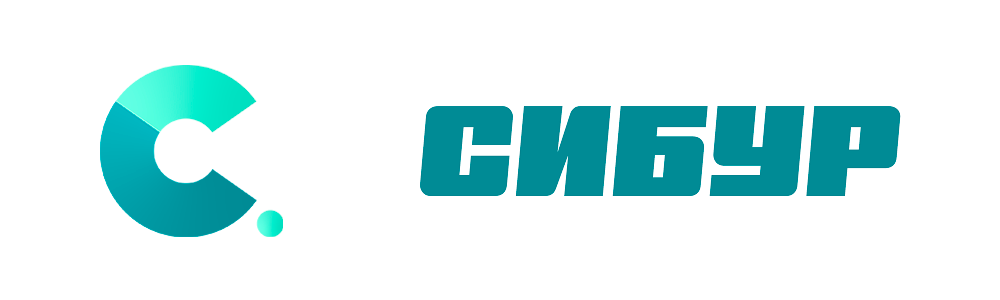

Решение команды Корделл основано на использовании Computer Vision для оптимизации проверки контейнеров на предмет брака.

Типов дефектов много, однако большая часть из них может быть выявлена с помощью Машинного Обучения: например, деформации контейнера, коррозия, нечитаемый текст нумерации контейнера или несовпадение информации нумерации с данными.

Таким образом, пайплайн решения состоит из нескольких моделей машинного обучения:


1.   Распознавание деформаций контейнера
  *   Модель для определения наличия деформации
  *   Модель для определения места, где произошла деформация
2.   Распознавание текста нумерации




# **Распознавание повреждений:**



Импортируем необходимые библиотеки и распакуем архив:

In [442]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install 'git+https://github.com/facebookresearch/detectron2'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-uols3z3f
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-uols3z3f
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp39-cp39-linux_x86_64.whl size=397883 sha256=ae5578e36d4186cb1f51deda54784cd4e90e5c965ab9bf97f203916d80d8d3ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-lps40t_u/wheels/13/c1/d6/a321055f7089f1a6af654fbf794536b196999f082a9cb68a37
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6
Looking in indexes: https://pypi.org/simple, ht

In [443]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

from scipy.spatial import distance

In [444]:
!unzip val.zip

Archive:  val.zip
   creating: val/
  inflating: val/broken.jpg          
  inflating: val/COCO_mul_val_annos.json  
  inflating: val/COCO_val_annos.json  
  inflating: val/door1.jpg           
  inflating: val/door2.jpg           
  inflating: val/door3.jpg           
  inflating: val/unbroken.jpg        


In [445]:
dataDir='/content/val'
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)

Инициализация COCO:

In [446]:
coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [447]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.13.1+cu116 False


Импорт detectron2:

In [448]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

plt.rcParams["figure.figsize"] = [16,9]

In [449]:
!python -m detectron2.utils.collect_env

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
-------------------------------  ----------------------------------------------------------------
sys.platform                     linux
Python                           3.9.16 (main, Dec  7 2022, 01:11:51) [GCC 9.4.0]
numpy                            1.22.4
detectron2                       0.6 @/usr/local/lib/python3.9/dist-packages/detectron2
Compiler                         GCC 9.4
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          1.13.1+cu116 @/usr/local/lib/python3.9/dist-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    No: torch.cuda.is_available() == False
Pillow                           8.4.0
torchvision                      0.14.1+cu116 @/usr/local/lib/python3.9/dist-packages/torchvision
fvcore                           0.1.5.post20221221
iopath                         

In [450]:
dataset_dir = "/content/val"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

In [451]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("container_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("container_mul_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_mul_val_annos.json"), os.path.join(dataset_dir,img_dir))

Выполним конфигурацию моделей детектрона:

In [452]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [453]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.RETINANET.NUM_CLASSES = 2
cfg.MODEL.WEIGHTS = os.path.join("drive/MyDrive/damage_segmentation_model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg['MODEL']['DEVICE']='cuda'
damage_predictor = DefaultPredictor(cfg)

RuntimeError: ignored

In [454]:
cfg_mul = get_cfg()
cfg_mul.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_mul.MODEL.ROI_HEADS.NUM_CLASSES = 6
cfg_mul.MODEL.RETINANET.NUM_CLASSES = 6
cfg_mul.MODEL.WEIGHTS = os.path.join("drive/MyDrive/part_segmentation_model.pth")
cfg_mul.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg_mul['MODEL']['DEVICE']='cuda'
part_predictor = DefaultPredictor(cfg_mul)

RuntimeError: ignored

Создадим класс для определения повреждённых частей контейнера:

In [ ]:
def detect_damage_part(damage_dict, parts_dict):
  try:
    max_distance = 10e9
    assert len(damage_dict)>0, "AssertError: damage_dict should have atleast one damage"
    assert len(parts_dict)>0, "AssertError: parts_dict should have atleast one part"
    max_distance_dict = dict(zip(damage_dict.keys(),[max_distance]*len(damage_dict)))
    part_name = dict(zip(damage_dict.keys(),['']*len(damage_dict)))

    for y in parts_dict.keys():
        for x in damage_dict.keys():
          dis = distance.euclidean(damage_dict[x], parts_dict[y])
          if dis < max_distance_dict[x]:
            part_name[x] = y.rsplit('_',1)[0]

    return list(set(part_name.values()))
  except Exception as e:
    print(e)

In [ ]:
damage_class_map= {0:'damage'}
parts_class_map={0:'front',1:'back', 2:'door', 3:'top', 4:'side'}

Протестируем на неповреждённом контейнере:

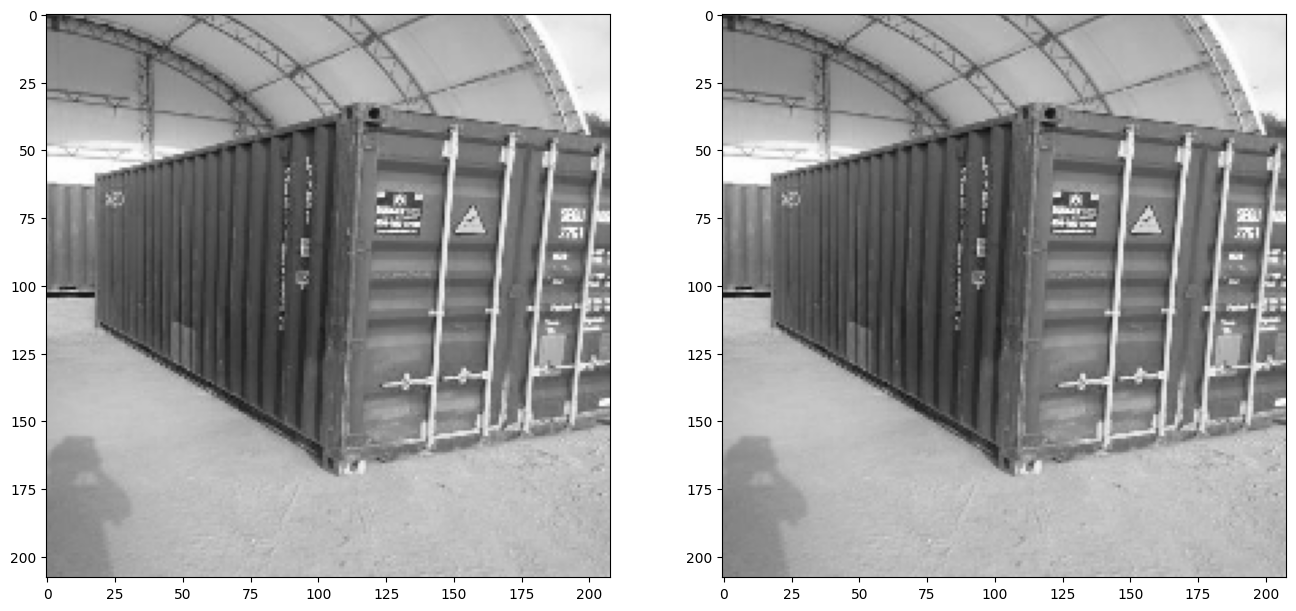

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,12))
im = io.imread("/content/val/unbroken.jpg")

damage_outputs = damage_predictor(im)
damage_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("container_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
)
damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

parts_outputs = part_predictor(im)
parts_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("container_mul_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
)
parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])

In [ ]:
damage_prediction_classes = [ damage_class_map[el] + "_" + str(indx) for indx,el in enumerate(damage_outputs["instances"].pred_classes.tolist())]
damage_polygon_centers = damage_outputs["instances"].pred_boxes.get_centers().tolist()
damage_dict = dict(zip(damage_prediction_classes,damage_polygon_centers))

In [ ]:
parts_prediction_classes = [ parts_class_map[el] + "_" + str(indx) for indx,el in enumerate(parts_outputs["instances"].pred_classes.tolist())]
parts_polygon_centers =  parts_outputs["instances"].pred_boxes.get_centers().tolist()

parts_polygon_centers_filtered = list(filter(lambda x: x[0] < 800 and x[1] < 800, parts_polygon_centers))
parts_dict = dict(zip(parts_prediction_classes,parts_polygon_centers_filtered))

**Вывод - контейнер не повреждён:**

In [ ]:
print("Повреждённые части: ",detect_damage_part(damage_dict,parts_dict))

AssertError: damage_dict should have atleast one damage
Damaged Parts:  None


Протестируем на повреждённом контейнере:

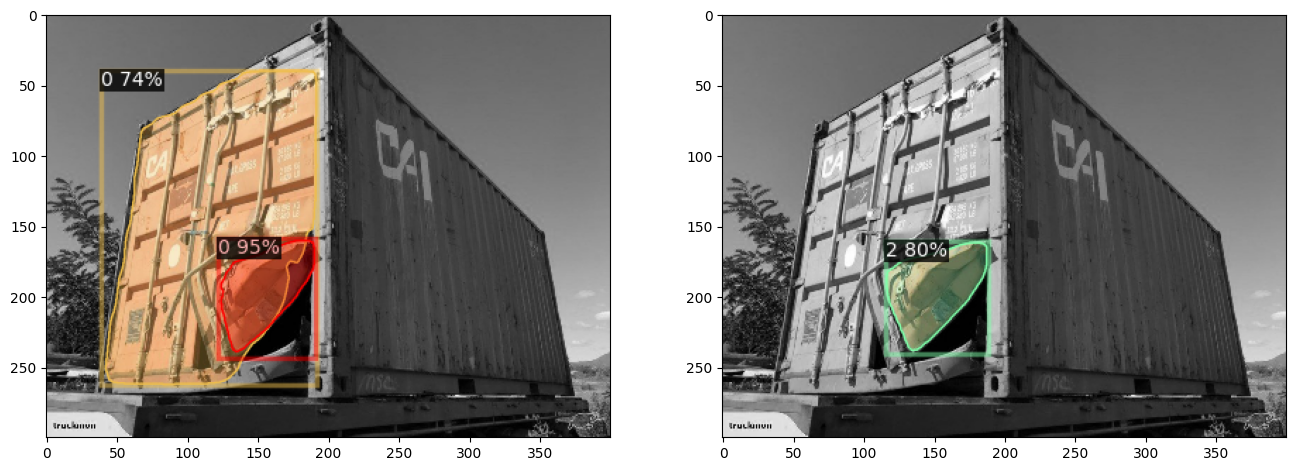

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,12))
im = io.imread("/content/val/broken.jpg")

damage_outputs = damage_predictor(im)
damage_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("container_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
)
damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

parts_outputs = part_predictor(im)
parts_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("container_mul_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
)
parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])

In [ ]:
damage_prediction_classes = [ damage_class_map[el] + "_" + str(indx) for indx,el in enumerate(damage_outputs["instances"].pred_classes.tolist())]
damage_polygon_centers = damage_outputs["instances"].pred_boxes.get_centers().tolist()
damage_dict = dict(zip(damage_prediction_classes,damage_polygon_centers))

In [ ]:
parts_prediction_classes = [ parts_class_map[el] + "_" + str(indx) for indx,el in enumerate(parts_outputs["instances"].pred_classes.tolist())]
parts_polygon_centers =  parts_outputs["instances"].pred_boxes.get_centers().tolist()

parts_polygon_centers_filtered = list(filter(lambda x: x[0] < 800 and x[1] < 800, parts_polygon_centers))
parts_dict = dict(zip(parts_prediction_classes,parts_polygon_centers_filtered))

**Вывод - у контейнера повреждена дверь:**

In [ ]:
print("Повреждённые части: ",detect_damage_part(damage_dict,parts_dict))

Damaged Parts:  ['door']


# **Распознавание текста:**

In [469]:
!pip install easyocr
import easyocr
from IPython.display import Image
reader = easyocr.Reader(["en"])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [470]:
result = reader.readtext("val/door1.jpg")

In [471]:
def get_final(result):
  for i in range(len(result)):
    result[i]=list(result[i])
  for i in result:
    if (len(i[1])<4):
      result.remove(i)
  for j in range(len(result)):
    y = 0
    x = 0
    for i in range(4):
      x += result[j][0][i][0]
      y += result[j][0][i][1]
    x /= 4
    y /= 4
    result[j].insert(0, x)
    result[j].insert(1, y)
    result[j].pop(2)
  result = sorted(result, key=itemgetter(1))[:3]
  help_needed='Помощь оператора не нужна'
  for word in result:
    if word[3] < 0.5:
      help_needed='Необходима помощь оператора'
      break
  final = []
  result = sorted(result, key=itemgetter(0))
  final.append(result[0][2].strip())
  result.pop(0)
  result = sorted(result, key=itemgetter(1))
  final.append(result[0][2].strip())
  final.append(result[1][2].strip())
  if final[2][2] == '6':
    final2_list = list(final[2])
    final2_list[2] = 'G'
    final[2] = ''.join(final2_list)
  for word in final:
    if ' ' in word:
      help_needed='Необходима помощь оператора'
      break
  for word in final:
    if len(word) > 6:
      help_needed='Необходима помощь оператора'
      break
  return final

In [472]:
get_final(result)

['MEDU', '248438', '22G1']

In [458]:
for i in range(len(result)):
  result[i]=list(result[i])

In [459]:
for i in result:
  if (len(i[1])<4):
    result.remove(i)

In [460]:
for j in range(len(result)):
  y = 0
  x = 0
  for i in range(4):
    x += result[j][0][i][0]
    y += result[j][0][i][1]
  x /= 4
  y /= 4
  result[j].insert(0, x)
  result[j].insert(1, y)
  result[j].pop(2)

In [461]:
from operator import itemgetter
result = sorted(result, key=itemgetter(1))[:3]

In [463]:
help_needed='Помощь оператора не нужна'
for word in result:
  if word[3] < 0.5:
    help_needed='Необходима помощь оператора'
    break

In [464]:
final = []
result = sorted(result, key=itemgetter(0))
final.append(result[0][2].strip())
result.pop(0)
result = sorted(result, key=itemgetter(1))
final.append(result[0][2].strip())
final.append(result[1][2].strip())

In [465]:
if final[2][2] == '6':
  final2_list = list(final[2])
  final2_list[2] = 'G'
  final[2] = ''.join(final2_list)

In [466]:
for word in final:
  if ' ' in word:
    help_needed='Необходима помощь оператора'
    break
for word in final:
  if len(word) > 6:
    help_needed='Необходима помощь оператора'
    break

In [467]:
print(final)
print(help_needed)

['MEDU', '248438', '22G1']
Помощь оператора не нужна
